# Extract PSF from beads image
This script is used to extract PSF from beads image stacks.

Zuhui Wang
2025-12-02

In [ ]:
from pathlib import Path
import nd2
import tifffile as tiff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import filters, measure, morphology
from scipy.spatial.distance import cdist
from scipy.ndimage import shift
from skimage.segmentation import clear_border

# -------------------------------
# 1. Segmentation
# -------------------------------
def segment_beads(image, sigma=1.0, min_size=20):
    """
    Segment beads from a z-projected image.
    Returns a labeled image.
    """
    blurred = filters.gaussian(image, sigma=sigma)
    thresh = filters.threshold_otsu(blurred)
    binary = blurred > thresh
    label_image = measure.label(binary)
    label_image = morphology.remove_small_objects(label_image, min_size=min_size)
    label_image = clear_border(label_image)
    return label_image

# -------------------------------
# 2. Compute statistics
# -------------------------------
def compute_stats(label_image, intensity_image):
    """
    Compute region properties for labeled beads.
    Returns a DataFrame with weighted_centroid and max intensity.
    """
    props = measure.regionprops_table(label_image, intensity_image=intensity_image,
                                      properties=('label', 'weighted_centroid', 'max_intensity'))
    return pd.DataFrame(props)

# -------------------------------
# 3. Filter beads by distance
# -------------------------------
def filter_by_distance(df, label_image, min_dist=21):
    """
    Remove beads that are too close to each other.
    """
    centers = df[["weighted_centroid-0", "weighted_centroid-1"]].to_numpy()
    dist_matrix = cdist(centers, centers)
    need_remove_idx = np.sum(dist_matrix < min_dist, axis=1) > 1
    keep_labels = df.loc[~need_remove_idx, "label"].to_numpy()
    mask = np.isin(label_image, keep_labels)
    return measure.label(mask)

# -------------------------------
# 4. Filter beads by intensity
# -------------------------------
def filter_by_intensity(df, label_image, min_int=1000, max_int=20000):
    """
    Remove beads that are too dim or too bright.
    """
    # low_photon = (df['max_intensity'] < min_int) | (df['max_intensity'] > max_int)
    low_photon = df['max_intensity'] < min_int
    keep_labels = df.loc[~low_photon, "label"].to_numpy()
    mask = np.isin(label_image, keep_labels)
    return measure.label(mask)

# -------------------------------
# 5. Average PSF
# -------------------------------
def sum_psf(bead_stack, df, psf_radius=10, z_length=None, focal_plane=100):
    """
    Translate bead images into a PSF window and average them.
    Returns the normalized PSF.
    """
    if z_length is None:
        z_length = bead_stack.shape[0]
    size = psf_radius * 2 + 1
    sum_psf = np.zeros((z_length, size, size), dtype=np.float32)

    for _, row in df.iterrows():
        y, x = row["weighted_centroid-0"], row["weighted_centroid-1"]
        # z = row.get(focal_plane, z_length // 2)

        translated = shift(bead_stack,
                           shift=(-focal_plane + z_length//2, -y + psf_radius, -x + psf_radius),
                           order=1, mode='constant')
        single_psf = translated[:z_length, :size, :size]
        sum_psf += single_psf

    return sum_psf

# -------------------------------
# 6. Visualization helper
# -------------------------------
def show_overlay(image, df):
    """
    Overlay bead centers and labels on an image.
    """
    centers = df[["weighted_centroid-0", "weighted_centroid-1"]].to_numpy()
    fig, ax = plt.subplots()
    ax.imshow(image, cmap='gray', vmin=400, vmax=5000)
    for i, (y, x) in enumerate(centers):
        ax.text(x, y, str(i), color='red')
    ax.scatter(centers[:, 1], centers[:, 0], color='red', s=2, alpha=0.7)
    plt.show()


## Step1: Define the bead image path

In [ ]:
# must convert ome.tif into regular tif first, otherwise has bug
beads_imgpath = [
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view02.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view03.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view04.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view05.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view06.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view07.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view08.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view09.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view10.tif',
    '/dataB/SPT_raw_backup/ZuhuiWang/2024/20240326_Qdot655/test/view11.tif',
    # '/mnt/disk1/WZH-DataCenter/PROCESS-SPT/MPALM_revision1/SMLM2016_challenge/sequence-as-stack-Beads-2D/sequence-as-stack-Beads-2D-Exp.tif'
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_C642_10nmZScan_007.nd2',
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_C642_10nmZScan_008.nd2',
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_C642_L1p5x_10nmZScan_009.nd2',
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_C642_L1p5x_10nmZScan_010.nd2', 
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_SR642_10nmZScan_003.nd2',
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_SR642_10nmZScan_004.nd2', 
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_SR642_L1p5x_10nmZScan_005.nd2',
    # '/dataB/CSUX1-backup/ZuhuiWang/2025/20251103_qdot655/qdot655_SR642_L1p5x_10nmZScan_006.nd2',
]

bead_images = []
for img_path in beads_imgpath:
    bead_image = tiff.imread(img_path)
    # Comment out above and uncomment below line if you are using nd2 format
    # bead_image = nd2.imread(img_path)
    bead_images.append(bead_image)

# Convert the list of arrays to a single 4D numpy array
bead_images = np.array(bead_images)
[img_number,z_length,img_height,img_width] = bead_images.shape
print(bead_images.shape)

# Define path and filename to save the PSF image
save_path = Path('/dataB/dell_process_backup/To20230604/WZH-DataCenter/PROCESS-SPT/2024/20240326_Qdot655')
save_name = 'averaged_psf_20251202_fromV2.tif'

## Step2: Extract PSF
Adjust parameters as needed, e.g., sigma, min_size, min_int, psf_radius, focal_plane

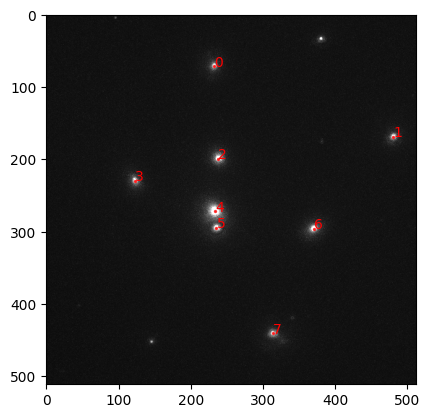

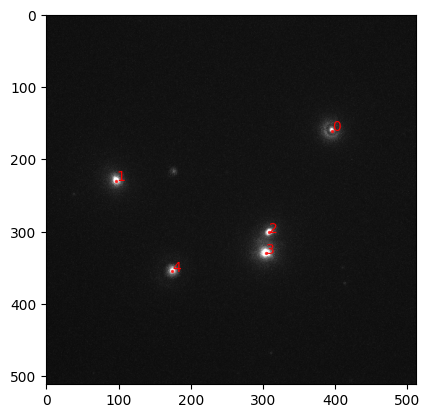

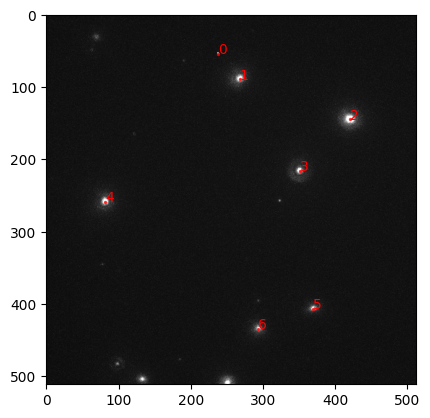

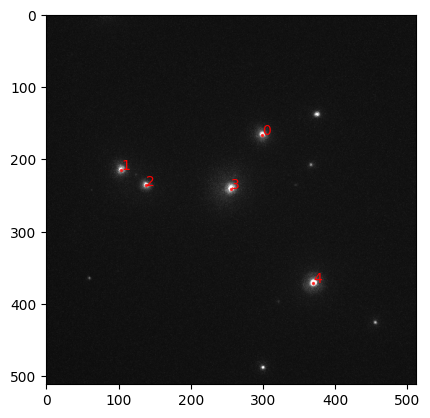

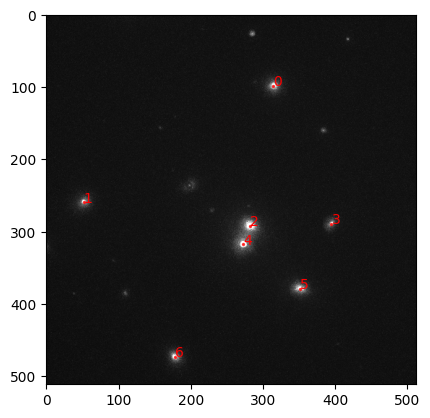

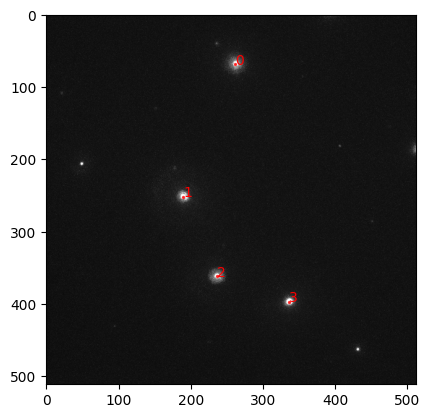

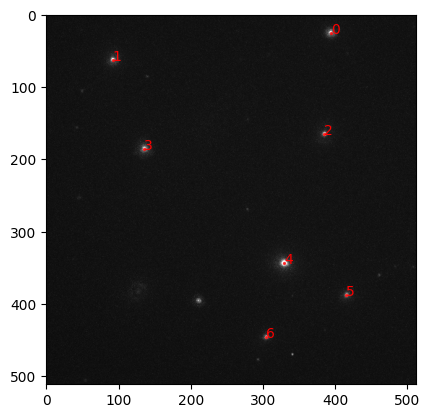

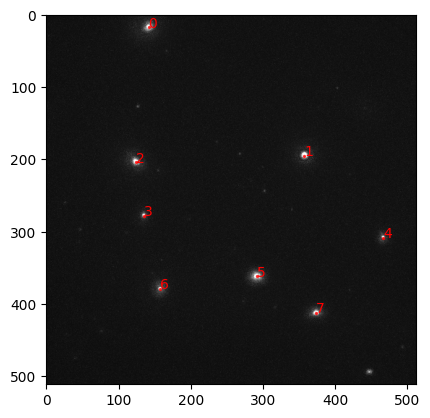

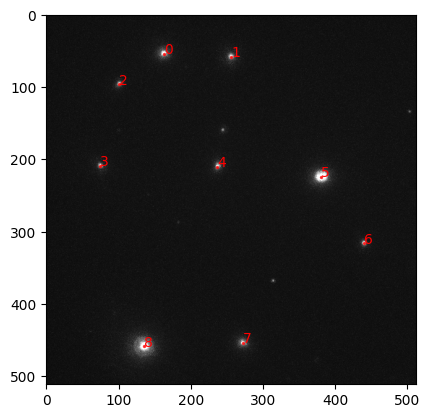

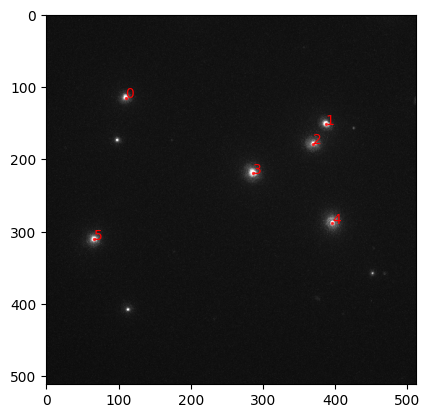

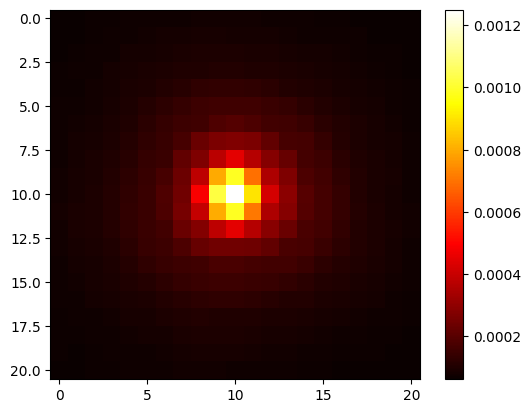

In [130]:
total_summed_psf = np.zeros((z_length, 21, 21), dtype=np.float32)

for iter in range(len(beads_imgpath)):
    # Step 1: Project along z
    max_z_img = np.max(bead_images[iter], axis=0)

    # Step 2: Segment
    labels = segment_beads(max_z_img, sigma=1.0, min_size=10)

    # Step 3: Stats
    df = compute_stats(labels, max_z_img)

    # Step 4: Filter by distance
    labels = filter_by_distance(df, labels)

    # Step 5: Filter by intensity
    df = compute_stats(labels, max_z_img)
    labels = filter_by_intensity(df, labels, min_int=5000)

    # Step 6: Overlay visualization
    show_overlay(max_z_img, df)

    # Step 7: Average PSF
    summed_psf = sum_psf(bead_images[iter], df, psf_radius=10, focal_plane=20)

    total_summed_psf = summed_psf + total_summed_psf

normalized_psf = total_summed_psf / total_summed_psf.sum()

plt.imshow(np.max(normalized_psf, axis=0), cmap='hot')
plt.colorbar()
plt.show()

# Save as TIFF
tiff.imwrite(save_path / save_name, normalized_psf.astype(np.float32))


## Step3: Fit PSF with 2D Gaussian Function
We then fit the focal plane of this PSF image stack (where the center of PSF get highest intensity) with a 2D symmetric Gaussian function to obtain the sigma value, which will later used in the snapshot simulation.

In [ ]:
# Read PSF image stacks if needed
# save_path = Path('/dataB/dell_process_backup/To20230604/WZH-DataCenter/PROCESS-SPT/2024/20240326_Qdot655')
# save_name = 'averaged_psf_20251202_fromV2.tif'
# # Save as TIFF
# normalized_psf = tiff.imread(save_path / save_name, normalized_psf.astype(np.float32))


max_intensity_per_z = normalized_psf.max(axis=(1,2))
focal_plane_index = np.argmax(max_intensity_per_z)

print("Estimated focal plane index:", focal_plane_index)

# # calculate FWHM
norm_psf_focal = normalized_psf[focal_plane_index,]
cam_pixel_size = 0.11 # in um
lamda = 0.655 # in um
NA = 1.49

import numpy as np
from scipy.optimize import curve_fit

# # Define 2D Gaussian
# def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, offset):
#     x, y = coords
#     g = A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) +
#                      ((y - y0) ** 2) / (2 * sigma_y ** 2))) + offset
#     return g.ravel()

def symmetric_gaussian_2d(coords, A, x0, y0, sigma, offset):
    x, y = coords
    g = A * np.exp(-((1/(2 * sigma ** 2))*((x - x0) ** 2  +  (y - y0) ** 2))) + offset
    return g.ravel()

# Your PSF image
psf = norm_psf_focal   # 2D numpy array

# Create coordinate grid
x = np.arange(psf.shape[1])
y = np.arange(psf.shape[0])
x, y = np.meshgrid(x, y)

# Initial guess for parameters
initial_guess = (1, psf.shape[1]//2, psf.shape[0]//2, 2, 0)

# Define bounds for each parameter
# lower bounds
lower_bounds = (0, 0, 0, 1, 0)   # amplitude ≥0, center ≥0, sigma >0, offset free
# upper bounds
upper_bounds = (np.inf, psf.shape[1], psf.shape[0], np.inf, np.inf)

# Fit Gaussian with bounds
popt, _ = curve_fit(
    symmetric_gaussian_2d,
    (x, y),
    psf.ravel(),
    p0=initial_guess,
    bounds=(lower_bounds, upper_bounds)
)

A, x0, y0, sigma, offset = popt

# Calculate FWHM
fwhm = 2.3548 * sigma

theoretical_FWHM = 0.51*lamda/NA

print(f"Theoretical FWHM = {theoretical_FWHM:.3f} um")

print(f"FWHM = {fwhm:.3f} pixels")

print(f"sigma = {sigma:.3f} pixels")

print(f"FWHM = {fwhm*cam_pixel_size:.3f} um")

# A, x0, y0, sigma_x, sigma_y, offset = popt

# # Calculate FWHM
# fwhm_x = 2.3548 * sigma_x
# fwhm_y = 2.3548 * sigma_y

# theoretical_FWHM = 0.51*lamda/NA

# print(f"Theoretical FWHM = {theoretical_FWHM:.3f} um")

# print(f"FWHM_x = {fwhm_x:.3f} pixels")
# print(f"FWHM_y = {fwhm_y:.3f} pixels")

# print(f"sigma_x = {sigma_x:.3f} pixels")
# print(f"sigma_y = {sigma_y:.3f} pixels")

# print(f"FWHM_x = {fwhm_x*cam_pixel_size:.3f} um")
# print(f"FWHM_y = {fwhm_y*cam_pixel_size:.3f} um")


Estimated focal plane index: 20
Theoretical FWHM = 0.224 um
FWHM = 3.132 pixels
sigma = 1.330 pixels
FWHM = 0.345 um


## Step4: Visualize fitting results of PSF with 2D Gaussian Function

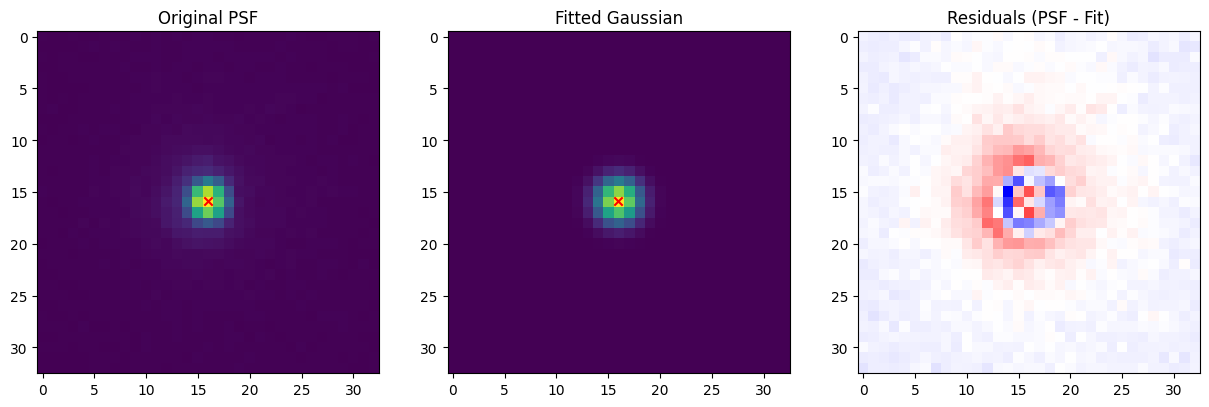

In [120]:
import matplotlib.pyplot as plt

# Reconstruct fitted Gaussian
fit = symmetric_gaussian_2d((x, y), A, x0, y0, sigma, offset).reshape(psf.shape)

# Plot original PSF
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original PSF image
axes[0].imshow(psf, cmap='viridis')
axes[0].set_title("Original PSF")
axes[0].scatter(x0, y0, color='r', marker='x')  # fitted center

# Fitted Gaussian image
axes[1].imshow(fit, cmap='viridis')
axes[1].set_title("Fitted Gaussian")
axes[1].scatter(x0, y0, color='r', marker='x')

# Residuals (difference)
residual = psf - fit
axes[2].imshow(residual, cmap='bwr', vmin=-np.max(np.abs(residual)), vmax=np.max(np.abs(residual)))
axes[2].set_title("Residuals (PSF - Fit)")

plt.show()


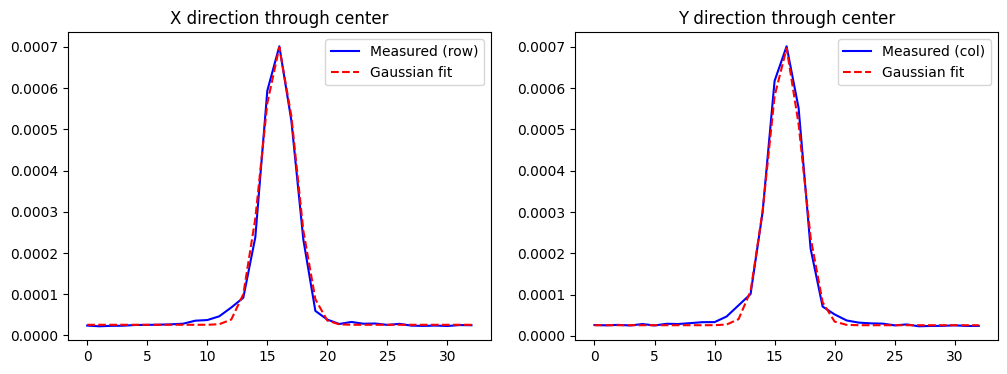

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# Assume psf, x0, y0, A, sigma_x, sigma_y, offset are already defined

# Round center to nearest pixel
x0_int, y0_int = int(round(x0)), int(round(y0))

# Extract measured line profiles
profile_x = psf[y0_int, :]        # row through center
profile_y = psf[:, x0_int]        # column through center

# Generate fitted Gaussian profiles along x and y
x_axis = np.arange(psf.shape[1])
y_axis = np.arange(psf.shape[0])

fit_x = A * np.exp(-((x_axis - x0)**2) / (2*sigma**2)) + offset
fit_y = A * np.exp(-((y_axis - y0)**2) / (2*sigma**2)) + offset

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x_axis, profile_x, 'b-', label='Measured (row)')
axes[0].plot(x_axis, fit_x, 'r--', label='Gaussian fit')
axes[0].set_title("X direction through center")
axes[0].legend()

axes[1].plot(y_axis, profile_y, 'b-', label='Measured (col)')
axes[1].plot(y_axis, fit_y, 'r--', label='Gaussian fit')
axes[1].set_title("Y direction through center")
axes[1].legend()

plt.show()
